##Script Variables
These are values that could be passed into this script as configuration

In [0]:
SF_URL = "https://rg93674.us-east-2.aws.snowflakecomputing.com"
SF_DATABASE = "USER_OSUSAM28"
SF_SCHEMA = "INTERVIEW"
SF_WAREHOUSE = "INTERVIEW_WH"

AIRLINES_TABLE_NAME = "AIRLINES"
AIRPORTS_TABLE_NAME = "AIRPORTS"
FLIGHTS_TABLE_NAME = "FLIGHTS"

AIRLINE_AIRPORT_MONTHLY_FLIGHT_CNT_VW_NAME = "AIRLINE_AIRPORT_MONTHLY_FLIGHT_CNT"
ON_TIME_AIRLINE_PTG_2015_VW_NAME = "ON_TIME_AIRLINE_PTG_2015"
AIRLINE_DELAYS_VW_NAME = "AIRLINE_DELAYS"
AIRPORT_CANCEL_REASONS_VW_NAME = "AIRPORT_CANCEL_REASONS"
AIRPORT_DELAY_REASONS_VW_NAME = "AIRPORT_DELAY_REASONS"
MOST_UNIQUE_ROUTES_AIRLINE_VW_NAME = "MOST_UNIQUE_ROUTES_AIRLINE"

In [0]:
%scala

val SF_URL = "https://rg93674.us-east-2.aws.snowflakecomputing.com"
val SF_DATABASE = "USER_OSUSAM28"
val SF_SCHEMA = "INTERVIEW"
val SF_WAREHOUSE = "INTERVIEW_WH"

val CREATE_AIRLINES_TABLE_SQL = """
CREATE TABLE IF NOT EXISTS AIRLINES (IATA_CODE STRING, AIRLINE STRING)
"""

val CREATE_AIRPORTS_TABLE_SQL = """
CREATE TABLE IF NOT EXISTS AIRPORTS (IATA_CODE STRING, AIRPORT STRING, CITY STRING, STATE STRING, COUNTRY STRING, LATITUDE NUMBER, LONGITUDE NUMBER)
"""

val CREATE_FLIGHTS_TABLE_SQL = """
CREATE TABLE IF NOT EXISTS FLIGHTS (YEAR NUMBER, MONTH NUMBER, DAY NUMBER, DAY_OF_WEEK NUMBER, AIRLINE STRING, FLIGHT_NUMBER STRING, TAIL_NUMBER STRING, ORIGIN_AIRPORT STRING, DESTINATION_AIRPORT STRING, SCHEDULED_DEPARTURE STRING, DEPARTURE_TIME STRING, DEPARTURE_DELAY NUMBER, TAXI_OUT NUMBER, WHEELS_OFF STRING, SCHEDULED_TIME NUMBER, ELAPSED_TIME NUMBER, AIR_TIME NUMBER, DISTANCE NUMBER, WHEELS_ON NUMBER, TAXI_IN NUMBER, SCHEDULED_ARRIVAL NUMBER, ARRIVAL_TIME STRING, ARRIVAL_DELAY STRING, DIVERTED NUMBER, CANCELLED NUMBER, CANCELLATION_REASON STRING, AIR_SYSTEM_DELAY NUMBER, SECURITY_DELAY NUMBER, AIRLINE_DELAY NUMBER, LATE_AIRCRAFT_DELAY NUMBER, WEATHER_DELAY NUMBER)
"""

val AIRLINE_AIRPORT_MONTHLY_FLIGHT_CNT_SQL = """
CREATE OR REPLACE VIEW AIRLINE_AIRPORT_MONTHLY_FLIGHT_CNT AS (
  WITH PIVOTED AS (
    SELECT AIRLINE, AIRPORT, 
    CASE WHEN MONTH = 1 THEN 1 ELSE 0 END JAN_FLIGHTS,
    CASE WHEN MONTH = 2 THEN 1 ELSE 0 END FEB_FLIGHTS,
    CASE WHEN MONTH = 3 THEN 1 ELSE 0 END MAR_FLIGHTS,
    CASE WHEN MONTH = 4 THEN 1 ELSE 0 END APR_FLIGHTS,
    CASE WHEN MONTH = 5 THEN 1 ELSE 0 END MAY_FLIGHTS,
    CASE WHEN MONTH = 6 THEN 1 ELSE 0 END JUN_FLIGHTS,
    CASE WHEN MONTH = 7 THEN 1 ELSE 0 END JUL_FLIGHTS,
    CASE WHEN MONTH = 8 THEN 1 ELSE 0 END AUG_FLIGHTS,
    CASE WHEN MONTH = 9 THEN 1 ELSE 0 END SEPT_FLIGHTS,
    CASE WHEN MONTH = 10 THEN 1 ELSE 0 END OCT_FLIGHTS,
    CASE WHEN MONTH = 11 THEN 1 ELSE 0 END NOV_FLIGHTS,
    CASE WHEN MONTH = 12 THEN 1 ELSE 0 END DEC_FLIGHTS
    FROM (
      SELECT MONTH, AIRLINE, ORIGIN_AIRPORT AIRPORT 
      FROM "USER_OSUSAM28"."INTERVIEW"."FLIGHTS"
      UNION ALL
      SELECT MONTH, AIRLINE, DESTINATION_AIRPORT AIRPORT
      FROM "USER_OSUSAM28"."INTERVIEW"."FLIGHTS"
    )
  )
  SELECT AIRLINES.AIRLINE, 
      AIRPORTS.AIRPORT, 
      SUM(JAN_FLIGHTS) JAN_FLIGHTS,
      SUM(FEB_FLIGHTS) FEB_FLIGHTS,
      SUM(MAR_FLIGHTS) MAR_FLIGHTS,
      SUM(APR_FLIGHTS) APR_FLIGHTS,
      SUM(MAY_FLIGHTS) MAY_FLIGHTS,
      SUM(JUN_FLIGHTS) JUN_FLIGHTS,
      SUM(JUL_FLIGHTS) JUL_FLIGHTS,
      SUM(AUG_FLIGHTS) AUG_FLIGHTS,
      SUM(SEPT_FLIGHTS) SEPT_FLIGHTS,
      SUM(OCT_FLIGHTS) OCT_FLIGHTS,
      SUM(NOV_FLIGHTS) NOV_FLIGHTS,
      SUM(DEC_FLIGHTS) DEC_FLIGHTS
  FROM PIVOTED
  JOIN "USER_OSUSAM28"."INTERVIEW"."AIRLINES" AIRLINES ON AIRLINES.IATA_CODE = PIVOTED.AIRLINE
  JOIN "USER_OSUSAM28"."INTERVIEW"."AIRPORTS" AIRPORTS ON AIRPORTS.IATA_CODE = PIVOTED.AIRPORT
  GROUP BY 1,2
  ORDER BY 1 DESC, 2 DESC
)
"""

val ON_TIME_AIRLINE_PTG_2015_SQL = """
CREATE OR REPLACE VIEW ON_TIME_AIRLINE_PTG_2015 AS (
  SELECT AIRLINES.AIRLINE, CNT/TOTAL_CNT ON_TIME_PTG
  FROM (
    SELECT AIRLINE, 
      CASE WHEN ARRIVAL_DELAY > 1 THEN TRUE ELSE FALSE END IS_DELAY, 
      COUNT(*) CNT, 
      SUM(CNT) OVER (PARTITION BY AIRLINE) TOTAL_CNT
    FROM "USER_OSUSAM28"."INTERVIEW"."FLIGHTS"
    WHERE YEAR = 2015
    GROUP BY 1, 2
  ) COUNTS 
  JOIN "USER_OSUSAM28"."INTERVIEW"."AIRLINES" AIRLINES ON COUNTS.AIRLINE = AIRLINES.IATA_CODE
  WHERE IS_DELAY = FALSE
)
"""

val AIRLINE_DELAYS_SQL = """
CREATE OR REPLACE VIEW AIRLINE_DELAYS AS (
  SELECT AIRLINES.AIRLINE, CNT DELAY_CNT
  FROM (
    SELECT AIRLINE, CASE WHEN ARRIVAL_DELAY > 1 THEN TRUE ELSE FALSE END IS_DELAY, COUNT(*) CNT
    FROM "USER_OSUSAM28"."INTERVIEW"."FLIGHTS"
    GROUP BY 1, 2
  ) COUNTS
  JOIN "USER_OSUSAM28"."INTERVIEW"."AIRLINES" AIRLINES ON COUNTS.AIRLINE = AIRLINES.IATA_CODE
  WHERE IS_DELAY = TRUE
)
"""

val AIRPORT_CANCEL_REASONS_SQL = """
CREATE OR REPLACE VIEW AIRPORT_CANCEL_REASONS (AIRPORT, CANCELLATION_REASON) AS (
  WITH CANCEL_REASONS AS (
    SELECT AIRPORTS.AIRPORT, 
        CASE WHEN CANCELLATION_REASON = 'A' THEN 'Airline/Carrier' 
            WHEN CANCELLATION_REASON = 'B' THEN 'Weather' 
            WHEN CANCELLATION_REASON = 'C' THEN 'National Air System' 
            WHEN CANCELLATION_REASON = 'D' THEN 'Security' 
            ELSE 'Other' END CANCELLATION_REASON
    FROM "USER_OSUSAM28"."INTERVIEW"."FLIGHTS" FLIGHTS
    JOIN "USER_OSUSAM28"."INTERVIEW"."AIRPORTS" AIRPORTS ON FLIGHTS.ORIGIN_AIRPORT = AIRPORTS.IATA_CODE
    WHERE CANCELLATION_REASON IS NOT NULL
    GROUP BY 1,2
  )
  SELECT AIRPORT, ARRAYAGG(DISTINCT CANCELLATION_REASON) CANCELLATION_REASONS
  FROM CANCEL_REASONS
  GROUP BY 1
)
"""

val AIRPORT_DELAY_REASONS_SQL = """
CREATE OR REPLACE VIEW AIRPORT_DELAY_REASONS AS (
  WITH REASONS_UNPIVOT AS (
    SELECT ORIGIN_AIRPORT, ARRAYAGG(DISTINCT DELAY_REASON) DELAY_REASONS
    FROM (
      SELECT ORIGIN_AIRPORT, DELAY, DELAY_TYPE DELAY_REASON
      FROM "USER_OSUSAM28"."INTERVIEW"."FLIGHTS" FLIGHTS
      UNPIVOT(DELAY for DELAY_TYPE in (AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY))
    ) 
    WHERE DELAY > 0
    GROUP BY 1
  ) 
  SELECT AIRPORTS.AIRPORT, DELAY_REASONS
  FROM REASONS_UNPIVOT
  JOIN "USER_OSUSAM28"."INTERVIEW"."AIRPORTS" AIRPORTS ON REASONS_UNPIVOT.ORIGIN_AIRPORT = AIRPORTS.IATA_CODE
)
"""

val MOST_UNIQUE_ROUTES_AIRLINE_SQL = """
CREATE OR REPLACE VIEW MOST_UNIQUE_ROUTES_AIRLINE AS (
  SELECT AIRLINES.AIRLINE, COUNT(*) DESTINATION_CNT
  FROM (
    SELECT DISTINCT AIRLINE, DESTINATION_AIRPORT
    FROM "USER_OSUSAM28"."INTERVIEW"."FLIGHTS"
  ) FLIGHTS
  JOIN "USER_OSUSAM28"."INTERVIEW"."AIRLINES" AIRLINES ON FLIGHTS.AIRLINE = AIRLINES.IATA_CODE
  GROUP BY 1
)
"""

SF_URL: String = https://rg93674.us-east-2.aws.snowflakecomputing.com
SF_DATABASE: String = USER_OSUSAM28
SF_SCHEMA: String = INTERVIEW
SF_WAREHOUSE: String = INTERVIEW_WH
CREATE_AIRLINES_TABLE_SQL: String =
"
CREATE TABLE IF NOT EXISTS AIRLINES (IATA_CODE STRING, AIRLINE STRING)
"
CREATE_AIRPORTS_TABLE_SQL: String =
"
CREATE TABLE IF NOT EXISTS AIRPORTS (IATA_CODE STRING, AIRPORT STRING, CITY STRING, STATE STRING, COUNTRY STRING, LATITUDE NUMBER, LONGITUDE NUMBER)
"
CREATE_FLIGHTS_TABLE_SQL: String =
"
CREATE TABLE IF NOT EXISTS FLIGHTS (YEAR NUMBER, MONTH NUMBER, DAY NUMBER, DAY_OF_WEEK NUMBER, AIRLINE STRING, FLIGHT_NUMBER STRING, TAIL_NUMBER STRING, ORIGIN_AIRPORT STRING, DESTINATION_AIRPORT STRING, SCHEDULED_DEPARTURE STRING, DEPARTURE_TIME STRING, DEPARTURE_DELAY NUMBER, TAXI_OUT NUMBER, WHEELS_OFF STRING, SCHEDULED_TIME NUMBER, ELAPSED_TIME NUMBER, AIR_TIME NUMBER, DISTANCE NUMBER, WHEELS_ON NUMBER, TAXI_IN NUMBER, SCHEDULED_ARRIVAL NUMBER, ARRIVAL_TIME STRING, ARRIVAL_DELAY STRING, DIVERTED NUMBER, CANCELLED NUMBER, CANCELLATION_REASON STRING, AIR_SYSTEM_DELAY NUMBER, SECURITY_DELAY NUMBER, AIRLINE_DELAY NUMBER, LATE_AIRCRAFT_DELAY NUMBER, WEATHER_DELAY NUMBER)
"
AIRLINE_AIRPORT_MONTHLY_FLIGHT_CNT_SQL: String =
"
CREATE OR REPLACE VIEW AIRLINE_AIRPORT_MONTHLY_FLIGHT_CNT AS (
 WITH PIVOTED AS (
 SELECT AIRLINE, AIRPORT,
 CASE WHEN MONTH = 1 THEN 1 ELSE 0 END JAN_FLIGHTS,
 CASE WHEN MONTH = 2 THEN 1 ELSE 0 END FEB_FLIGHTS,
 CASE WHEN MONTH = 3 THEN 1 ELSE 0 END MAR_FLIGHTS,
 CASE WHEN MONTH = 4 THEN 1 ELSE 0 END APR_FLIGHTS,
 CASE WHEN MONTH = 5 THEN 1 ELSE 0 END MAY_FLIGHTS,
 CASE WHEN MONTH = 6 THEN 1 ELSE 0 END JUN_FLIGHTS,
 CASE WHEN MONTH = 7 THEN 1 ELSE 0 END JUL_FLIGHTS,
 CASE WHEN MONTH = 8 THEN 1 ELSE 0 END AUG_FLIGHTS,
 CASE WHEN MONTH = 9 THEN 1 ELSE 0 END SEPT_FLIGHTS,
 CASE WHEN MONTH = 10 THEN 1 ELSE 0 END OCT_FLIGHTS,
 CASE WHEN MONTH = 11 THEN 1 ELSE 0 END NOV_FLIGHTS,
 CASE WHEN MONTH = 12 THEN 1 ELSE 0 END DEC_FLIGHTS
 FROM (
 SELECT MONTH, AIRLINE, ORIGIN_AIRPORT AIRPORT
 FROM "USER_OSUSAM28"."INTERVIEW"."FLIGHTS"
 UNION ALL
 SELECT MONTH, AIRLINE, DESTINATION_AIRPORT AIRPORT
 FROM "USER_OSUSAM28"."INTERVIEW"."FLIGHTS"
 )
 )
 SELECT AIRLINES.AIRLINE,
 AIRPORTS.AIRPORT,
 SUM(JAN_FLIGHTS) JAN_FLIGHTS,
 SUM(FEB_FLIGHTS) FEB_FLIGHTS,
 SUM(MAR_FLIGHTS) MAR_FLIGHTS,
 SUM(APR_FLIGHTS) APR_FLIGHTS,
 SUM(MAY_FLIGHTS) MAY_FLIGHTS,
 SUM(JUN_FLIGHTS) JUN_FLIGHTS,
 SUM(JUL_FLIGHTS) JUL_FLIGHTS,
 SUM(AUG_FLIGHTS) AUG_FLIGHTS,
 SUM(SEPT_FLIGHTS) SEPT_FLIGHTS,
 SUM(OCT_FLIGHTS) OCT_FLIGHTS,
 SUM(NOV_FLIGHTS) NOV_FLIGHTS,
 SUM(DEC_FLIGHTS) DEC_FLIGHTS
 FROM PIVOTED
 JOIN "USER_OSUSAM28"."INTERVIEW"."AIRLINES" AIRLINES ON AIRLINES.IATA_CODE = PIVOTED.AIRLINE
 JOIN "USER_OSUSAM28"."INTERVIEW"."AIRPORTS" AIRPORTS ON AIRPORTS.IATA_CODE = PIVOTED.AIRPORT
 GROUP BY 1,2
 ORDER BY 1 DESC, 2 DESC
)
"
ON_TIME_AIRLINE_PTG_2015_SQL: String =
"
CREATE OR REPLACE VIEW ON_TIME_AIRLINE_PTG_2015 AS (
 SELECT AIRLINES.AIRLINE, CNT/TOTAL_CNT ON_TIME_PTG
 FROM (
 SELECT AIRLINE,
 CASE WHEN ARRIVAL_DELAY > 1 THEN TRUE ELSE FALSE END IS_DELAY,
 COUNT(*) CNT,
 SUM(CNT) OVER (PARTITION BY AIRLINE) TOTAL_CNT
 FROM "USER_OSUSAM28"."INTERVIEW"."FLIGHTS"
 WHERE YEAR = 2015
 GROUP BY 1, 2
 ) COUNTS
 JOIN "USER_OSUSAM28"."INTERVIEW"."AIRLINES" AIRLINES ON COUNTS.AIRLINE = AIRLINES.IATA_CODE
 WHERE IS_DELAY = FALSE
)
"
AIRLINE_DELAYS_SQL: String =
"
CREATE OR REPLACE VIEW AIRLINE_DELAYS AS (
 SELECT AIRLINES.AIRLINE, CNT DELAY_CNT
 FROM (
 SELECT AIRLINE, CASE WHEN ARRIVAL_DELAY > 1 THEN TRUE ELSE FALSE END IS_DELAY, COUNT(*) CNT
 FROM "USER_OSUSAM28"."INTERVIEW"."FLIGHTS"
 GROUP BY 1, 2
 ) COUNTS
 JOIN "USER_OSUSAM28"."INTERVIEW"."AIRLINES" AIRLINES ON COUNTS.AIRLINE = AIRLINES.IATA_CODE
 WHERE IS_DELAY = TRUE
)
"
AIRPORT_CANCEL_REASONS_SQL: String =
"
CREATE OR REPLACE VIEW AIRPORT_CANCEL_REASONS (AIRPORT, CANCELLATION_REASON) AS (
 WITH CANCEL_REASONS AS (
 SELECT AIRPORTS.AIRPORT,
 CASE WHEN CANCELLATION_REASON = 'A' THEN 'Airline/Carrier'
 WHEN

##Snowflake Connector Configuration
Python and scala objects for connecting to a snowflake instance

In [0]:
user = "osusam28"
password = "#########"

sf_options = {
  "sfUrl": SF_URL,
  "sfUser": user,
  "sfPassword": password,
  "sfDatabase": SF_DATABASE,
  "sfSchema": SF_SCHEMA,
  "sfWarehouse": SF_WAREHOUSE,
  "truncate_table": "on",
  "purge": "on"
}

In [0]:
%scala
import net.snowflake.spark.snowflake.Utils

val user = "osusam28"
val password = "#########"

val sf_options = Map(
  "sfUrl" -> SF_URL,
  "sfUser" -> user,
  "sfPassword" -> password,
  "sfDatabase" -> SF_DATABASE,
  "sfSchema" -> SF_SCHEMA,
  "sfWarehouse" -> SF_WAREHOUSE
)

import net.snowflake.spark.snowflake.Utils
user: String = osusam28
password: String = Lizards1@
sf_options: scala.collection.immutable.Map[String,String] = Map(sfUrl -> https://rg93674.us-east-2.aws.snowflakecomputing.com, sfSchema -> INTERVIEW, sfPassword -> Lizards1@, sfUser -> osusam28, sfWarehouse -> INTERVIEW_WH, sfDatabase -> USER_OSUSAM28)

##Read Uploaded Files
Files were uploaded to DBFS and are read into dataframes

In [0]:
airlines_df = spark.read.format("csv").options(header='true', inferSchema='false').load("dbfs:/FileStore/shared_uploads/osusam28@gmail.com/airlines.csv")
airports_df = spark.read.format("csv").options(header='true', inferSchema='false').load("dbfs:/FileStore/shared_uploads/osusam28@gmail.com/airports.csv")
flights_df = spark.read.format("csv").options(header='true', inferSchema='false').load("dbfs:/FileStore/shared_uploads/osusam28@gmail.com/partition_*.csv")

##Setup Snowflake Tables
Scripts to create empty tables for the source data if they don't already exist

In [0]:
%scala

Utils.runQuery(sf_options, CREATE_AIRLINES_TABLE_SQL)
Utils.runQuery(sf_options, CREATE_AIRPORTS_TABLE_SQL)
Utils.runQuery(sf_options, CREATE_FLIGHTS_TABLE_SQL)

res0: java.sql.ResultSet = net.snowflake.client.jdbc.SnowflakeResultSetV1@2b13f319

##Write to Snowflake Tables
Use the snowflake connection to write the dataframes to the tables

In [0]:
airlines_df.write \
  .format("snowflake") \
  .options(**sf_options) \
  .option("dbtable", AIRLINES_TABLE_NAME) \
  .mode("overwrite") \
  .save()

airports_df.write \
  .format("snowflake") \
  .options(**sf_options) \
  .option("dbtable", AIRPORTS_TABLE_NAME) \
  .mode("overwrite") \
  .save()

flights_df.write \
  .format("snowflake") \
  .options(**sf_options) \
  .option("dbtable", FLIGHTS_TABLE_NAME) \
  .mode("overwrite") \
  .save()

##Create Snowflake Views
Scripts to create views off of the source tables in Snowflake

In [0]:
%scala

Utils.runQuery(sf_options, AIRLINE_AIRPORT_MONTHLY_FLIGHT_CNT_SQL)
Utils.runQuery(sf_options, ON_TIME_AIRLINE_PTG_2015_SQL)
Utils.runQuery(sf_options, AIRLINE_DELAYS_SQL)
Utils.runQuery(sf_options, AIRPORT_CANCEL_REASONS_SQL)
Utils.runQuery(sf_options, AIRPORT_DELAY_REASONS_SQL)
Utils.runQuery(sf_options, MOST_UNIQUE_ROUTES_AIRLINE_SQL)

res1: java.sql.ResultSet = net.snowflake.client.jdbc.SnowflakeResultSetV1@1b60f686

##Read In Data From Views
Read data from views into dataframes

In [0]:
flight_cnt_df = spark.read \
  .format("snowflake") \
  .options(**sf_options) \
  .option("dbtable",  AIRLINE_AIRPORT_MONTHLY_FLIGHT_CNT_VW_NAME) \
  .load()

on_time_df = spark.read \
  .format("snowflake") \
  .options(**sf_options) \
  .option("dbtable",  ON_TIME_AIRLINE_PTG_2015_VW_NAME) \
  .load()

delays_df = spark.read \
  .format("snowflake") \
  .options(**sf_options) \
  .option("dbtable",  AIRLINE_DELAYS_VW_NAME) \
  .load()

cancel_rns_df = spark.read \
  .format("snowflake") \
  .options(**sf_options) \
  .option("dbtable",  AIRPORT_CANCEL_REASONS_VW_NAME) \
  .load()

delay_rns_df = spark.read \
  .format("snowflake") \
  .options(**sf_options) \
  .option("dbtable",  AIRPORT_DELAY_REASONS_VW_NAME) \
  .load()

unique_routes_df = spark.read \
  .format("snowflake") \
  .options(**sf_options) \
  .option("dbtable",  MOST_UNIQUE_ROUTES_AIRLINE_VW_NAME) \
  .load()

##Show the Data!
Visualize each view's dataframe

####Total number of flights by airline and airport on a monthly basis

In [0]:
display(flight_cnt_df)

AIRLINE,AIRPORT,JAN_FLIGHTS,FEB_FLIGHTS,MAR_FLIGHTS,APR_FLIGHTS,MAY_FLIGHTS,JUN_FLIGHTS,JUL_FLIGHTS,AUG_FLIGHTS,SEPT_FLIGHTS,OCT_FLIGHTS,NOV_FLIGHTS,DEC_FLIGHTS
Virgin America,Washington Dulles International Airport,234,200,227,293,284,296,296,299,0,0,0,0
Virgin America,Tulsa International Airport,0,0,0,0,1,0,0,0,0,0,0,0
Virgin America,Seattle-Tacoma International Airport,384,334,392,426,390,388,396,394,0,0,0,0
Virgin America,San Francisco International Airport,2701,2401,2756,2758,2874,2910,2999,3343,0,0,0,0
Virgin America,San Diego International Airport (Lindbergh Field),276,244,276,270,326,344,352,366,0,0,0,0
Virgin America,Ronald Reagan Washington National Airport,222,202,230,224,226,224,230,228,0,0,0,0
Virgin America,Portland International Airport,61,56,62,60,62,60,62,84,0,0,0,0
Virgin America,Palm Springs International Airport,63,58,81,80,0,0,0,0,0,0,0,0
Virgin America,Orlando International Airport,62,56,62,60,62,60,62,62,0,0,0,0
Virgin America,Newark Liberty International Airport,288,260,338,328,342,360,368,368,0,0,0,0


####On time percentage of each airline for the year 2015 (on time = delay <= 1 min)

/databricks/spark/python/pyspark/sql/pandas/utils.py:79: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [ON_TIME_PTG] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
 warnings.warn(

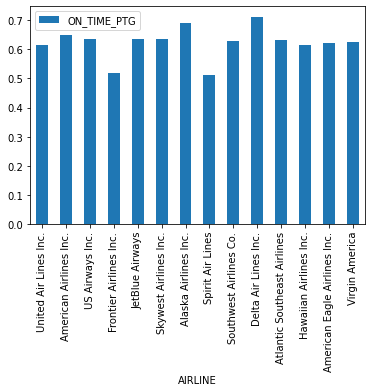

In [0]:
on_time_df_pandas = on_time_df.toPandas()
on_time_df_pandas['ON_TIME_PTG'] = on_time_df_pandas['ON_TIME_PTG'].astype(float)
ax = on_time_df_pandas.plot.bar(x='AIRLINE', y='ON_TIME_PTG', rot=90)

####Airlines with the largest number of delays (delay = delay > 1 min)

/databricks/spark/python/pyspark/sql/pandas/utils.py:79: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [DELAY_CNT] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
 warnings.warn(

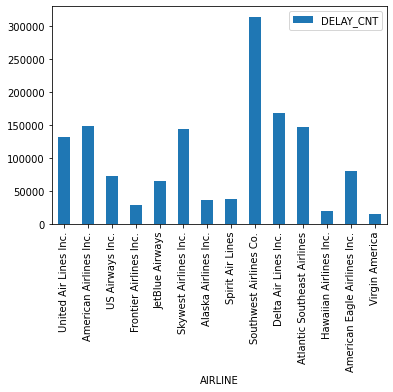

In [0]:
delays_df_pandas = delays_df.toPandas()
delays_df_pandas['DELAY_CNT'] = delays_df_pandas['DELAY_CNT'].astype(int)
ax = delays_df_pandas.plot.bar(x='AIRLINE', y='DELAY_CNT', rot=90)

####Cancellation reasons by airport

In [0]:
display(cancel_rns_df.orderBy('AIRPORT'))

AIRPORT,CANCELLATION_REASON
Aberdeen Regional Airport,"[ ""Weather"", ""Airline/Carrier"" ]"
Abilene Regional Airport,"[ ""Airline/Carrier"", ""Weather"" ]"
Abraham Lincoln Capital Airport,"[ ""Weather"", ""Airline/Carrier"", ""National Air System"" ]"
Adak Airport,"[ ""Weather"" ]"
Akron-Canton Regional Airport,"[ ""Weather"", ""National Air System"", ""Airline/Carrier"" ]"
Albany International Airport,"[ ""Weather"", ""Airline/Carrier"", ""National Air System"" ]"
Albert J. Ellis Airport,"[ ""Airline/Carrier"", ""National Air System"", ""Weather"" ]"
Albuquerque International Sunport,"[ ""National Air System"", ""Weather"", ""Airline/Carrier"" ]"
Alexandria International Airport,"[ ""National Air System"", ""Airline/Carrier"", ""Weather"" ]"
Alpena County Regional Airport,"[ ""Airline/Carrier"", ""National Air System"", ""Weather"" ]"


####Delay reasons by airport

In [0]:
display(delay_rns_df.orderBy('AIRPORT'))

AIRPORT,DELAY_REASONS
Aberdeen Regional Airport,"[ ""AIRLINE_DELAY"", ""WEATHER_DELAY"", ""LATE_AIRCRAFT_DELAY"", ""AIR_SYSTEM_DELAY"", ""SECURITY_DELAY"" ]"
Abilene Regional Airport,"[ ""WEATHER_DELAY"", ""AIRLINE_DELAY"", ""LATE_AIRCRAFT_DELAY"", ""AIR_SYSTEM_DELAY"", ""SECURITY_DELAY"" ]"
Abraham Lincoln Capital Airport,"[ ""LATE_AIRCRAFT_DELAY"", ""AIRLINE_DELAY"", ""WEATHER_DELAY"", ""SECURITY_DELAY"", ""AIR_SYSTEM_DELAY"" ]"
Adak Airport,"[ ""SECURITY_DELAY"", ""AIRLINE_DELAY"", ""AIR_SYSTEM_DELAY"", ""LATE_AIRCRAFT_DELAY"", ""WEATHER_DELAY"" ]"
Akron-Canton Regional Airport,"[ ""AIR_SYSTEM_DELAY"", ""LATE_AIRCRAFT_DELAY"", ""WEATHER_DELAY"", ""AIRLINE_DELAY"" ]"
Albany International Airport,"[ ""AIR_SYSTEM_DELAY"", ""WEATHER_DELAY"", ""AIRLINE_DELAY"", ""SECURITY_DELAY"", ""LATE_AIRCRAFT_DELAY"" ]"
Albert J. Ellis Airport,"[ ""LATE_AIRCRAFT_DELAY"", ""AIR_SYSTEM_DELAY"", ""AIRLINE_DELAY"" ]"
Albuquerque International Sunport,"[ ""SECURITY_DELAY"", ""AIRLINE_DELAY"", ""WEATHER_DELAY"", ""LATE_AIRCRAFT_DELAY"", ""AIR_SYSTEM_DELAY"" ]"
Alexandria International Airport,"[ ""AIRLINE_DELAY"", ""WEATHER_DELAY"", ""AIR_SYSTEM_DELAY"", ""SECURITY_DELAY"", ""LATE_AIRCRAFT_DELAY"" ]"
Alpena County Regional Airport,"[ ""LATE_AIRCRAFT_DELAY"", ""WEATHER_DELAY"", ""AIRLINE_DELAY"", ""AIR_SYSTEM_DELAY"" ]"


####Airline with the most unique routes

In [0]:
display(unique_routes_df)

AIRLINE,DESTINATION_CNT
Frontier Airlines Inc.,63
Hawaiian Airlines Inc.,17
Delta Air Lines Inc.,155
Skywest Airlines Inc.,198
American Eagle Airlines Inc.,129
Virgin America,18
Spirit Air Lines,34
Alaska Airlines Inc.,63
American Airlines Inc.,94
US Airways Inc.,79
